In [75]:
import chromatix.functional as cf
import jax.numpy as jnp
from chromatix.utils.fft import fft, ifft
from jax import Array
from jax.lax import scan
from jax.typing import ArrayLike
from sample import paper_sample
from tensor_tomo import outer, matvec, eps
import matplotlib.pyplot as plt
import numpy as np
from sample import single_bead_sample

from chromatix.utils import sigmoid_taper
%config InlineBackend.figure_format='retina'

In [84]:
# Our input field is a plane wave
n_upscale = 5
shape = (n_upscale * 280, n_upscale * 280) # field size
spacing = 0.065 # from paper
wavelength = 0.405 # from paper
nm = 1.33


In [124]:
# ROtating incoming wave
def rotate_polarisation(polarisation, theta, phi):
    # Invert x and z
    polarisation = polarisation[::-1]

    # Create the matrix M
    M = jnp.array([
        [1 + (jnp.cos(theta) - 1) * jnp.cos(phi)**2, (jnp.cos(theta) - 1) * jnp.cos(phi) * jnp.sin(phi), -jnp.sin(theta) * jnp.cos(phi)],
        [(jnp.cos(theta) - 1) * jnp.cos(phi) * jnp.sin(phi), 1 + (jnp.cos(theta) - 1) * jnp.sin(phi)**2, -jnp.sin(theta) * jnp.sin(phi)],
        [jnp.sin(theta) * jnp.cos(phi), jnp.sin(theta) * jnp.sin(phi), jnp.cos(theta)]
    ])
    
    # Perform a full 3D transpose (exchange both rows and columns)
    return (M @ polarisation)[::-1]

polarisation = rotate_polarisation(cf.linear(0), -jnp.deg2rad(45), -jnp.deg2rad(36.87),)

In [125]:
polarisation

Array([-0.56568474+0.j,  0.14058891+0.j,  0.8125488 +0.j], dtype=complex64)

In [126]:
kykx = 2 * jnp.pi  / wavelength * jnp.array([-jnp.deg2rad(45), -jnp.deg2rad(36.87),])
print(kykx)

[-12.184697  -9.983329]


In [127]:
in_field = cf.plane_wave(shape, spacing, wavelength, 1.0, amplitude=polarisation, scalar=False, power=100, kykx=kykx)
# Using gaussian beam
n_in = 320
in_field = in_field.replace(u=in_field.u * cf.center_pad(u=sigmoid_taper((n_in, n_in), 5), pad_width=(0, (shape[0] - n_in) // 2, (shape[1] - n_in) // 2, 0, 0)))
#in_field = in_field.replace(u=in_field.u * jnp.sqrt(jnp.exp(-jnp.sum(in_field.grid**2, axis=0) / (2 * 4.0**2)))) # gaussian 

In [128]:
# Sample from the paper

def paper_sample() -> Array:
    """Returns bead sample from paper."""

    def bead(orientation: Array) -> Array:
        n_m = 1.33
        n_bead = jnp.array([1.44, 1.40, 1.37])  # z y x
        bead_radius = 1.5
        spacing = 0.065 # mum
        k0 = 2 * jnp.pi / 0.405  # mum
        shape = (4.55 // spacing, (18.2 / 2) // spacing, (18.2 / 2) // spacing)  # z y x # / 2 as we have only 1 bead
        antialiasing = 5

        return single_bead_sample(
            n_m, n_bead, orientation, bead_radius, shape, spacing, k0, antialiasing
        )

    sample = jnp.concat(
        [
            jnp.concat(
                [
                    bead(jnp.array([0, 0, jnp.pi / 2])),
                    bead(jnp.array([jnp.pi/4, jnp.pi / 4, jnp.pi / 4])),
                ],
                axis=2,
            ),
            jnp.concat(
                [
                    bead(jnp.array([0, jnp.pi / 2, 0])),
                    bead(jnp.array([0, 0, 0])),
                ],
                axis=2,
            )
        ],
        axis=1,
    )
    return sample


sample = paper_sample()
print(f"Sample shape: {sample.shape}")

sample = cf.center_pad(sample, (0, (n_upscale-1)//2 * 280, (n_upscale-1) //2 * 280, 0, 0))
print(f"Padded sample shape: {sample.shape}")


Sample shape: (70, 280, 280, 3, 3)
Padded sample shape: (70, 1400, 1400, 3, 3)


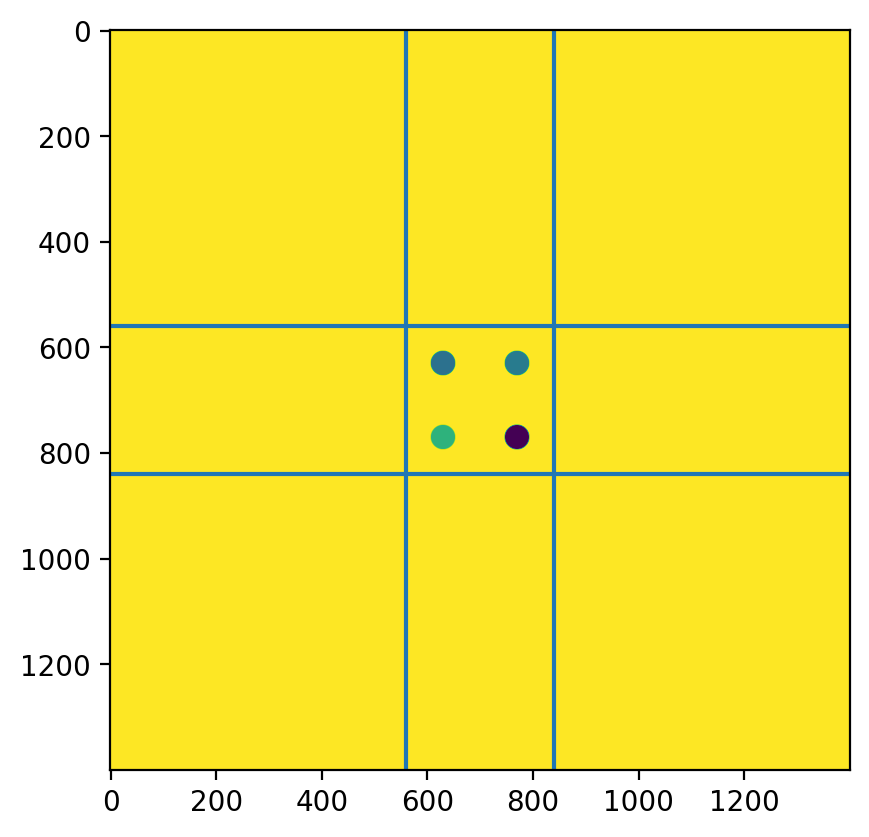

In [129]:
plt.imshow(sample[35, :, :, 0, 0])
plt.axhline((n_upscale -1) // 2 * 280)
plt.axhline((n_upscale -1) // 2 * 280 + 280)
plt.axvline((n_upscale -1) // 2 * 280)
plt.axvline((n_upscale -1) // 2 * 280 + 280)

In [130]:
def thick_polarised_sample_evanescent(field: cf.VectorField, potential: ArrayLike, nm: ArrayLike, dz: ArrayLike) -> cf.VectorField:
    def Q_op(u: Array) -> Array:
        # correct
        """Polarisation transfer operator"""
        u = jnp.pad(u, padding)
        return ifft(matvec(Q, fft(u)))[:, n_pad[0]: -n_pad[0], n_pad[1]:-n_pad[1]]
    
    def H_op(u: Array) -> Array:
        # correct
        """Vectorial scattering operator"""
        u = jnp.pad(u, padding)
        prefactor = -1j / 2 * jnp.exp(1j * kz * dz) / kz * dz
        return ifft(matvec(Q, prefactor * fft(u)))[:, n_pad[0]: -n_pad[0], n_pad[1]:-n_pad[1]]
    
    def P_op(u: Array) -> Array:
        # correct
        """Vectorial free space operator"""
        u = jnp.pad(u, padding)
        prefactor =  jnp.exp(1j * kz * dz)
        return ifft(matvec(Q, prefactor * fft(u)))[:, n_pad[0]: -n_pad[0], n_pad[1]:-n_pad[1]]

    def propagate_slice(u: Array, potential_slice: Array) -> tuple[Array, None]:
        scatter_field = matvec(potential_slice, Q_op(u))
        return P_op(u) + H_op(scatter_field), None

   
    # We use z yx ordering, and add the 2pi factor to chromatix kgrrid
    # We chop off evanescent waves
    # NOTE: understand why we need nm here
    padded_shape = np.array(field.shape[1:3]) + np.array(potential.shape[1:3])
    n_pad = (padded_shape - np.array(field.shape[1:3])) // 2
    padding = ((0, 0), (n_pad[0], n_pad[0]), (n_pad[1], n_pad[1]), (0, 0), (0, 0))

    k_grid = 2 * jnp.pi * jnp.stack(jnp.meshgrid(jnp.fft.fftfreq(n=padded_shape[0], d=spacing), jnp.fft.fftfreq(n=padded_shape[1], d=spacing), indexing='ij'))[:, None, ..., None, None]
    km = 2 * jnp.pi * nm / field.spectrum
    kz = jnp.sqrt(km**2 - jnp.sum(k_grid**2, axis=0, dtype=jnp.complex64))
    k_grid =  jnp.concatenate([kz[None, ...], k_grid], axis=0)

    # Calculating PTFT
    Q = (-outer(k_grid / km, k_grid / km, in_axis=0) + jnp.eye(3)).squeeze(-3)

    # Running scan over sample
    u, _ = scan(propagate_slice, field.u, potential[..., None, :, :])
    return field.replace(u=u)

In [134]:
# Running the simulation
field = thick_polarised_sample_evanescent(in_field, sample, 1.33, 0.065)

# Making plotting a little easier
# ::-1 to invert y axis
amplitude = field.amplitude.squeeze()
amplitude = amplitude[::-1][(n_upscale -1) // 2 * 280: (n_upscale -1) // 2 * 280 + 280, (n_upscale -1) // 2 * 280: (n_upscale -1) // 2 * 280 + 280]

phase = field.phase.squeeze()
phase = phase[::-1][(n_upscale -1) // 2 * 280: (n_upscale -1) // 2 * 280 + 280 , (n_upscale -1) // 2 * 280: (n_upscale -1) // 2 * 280 + 280]

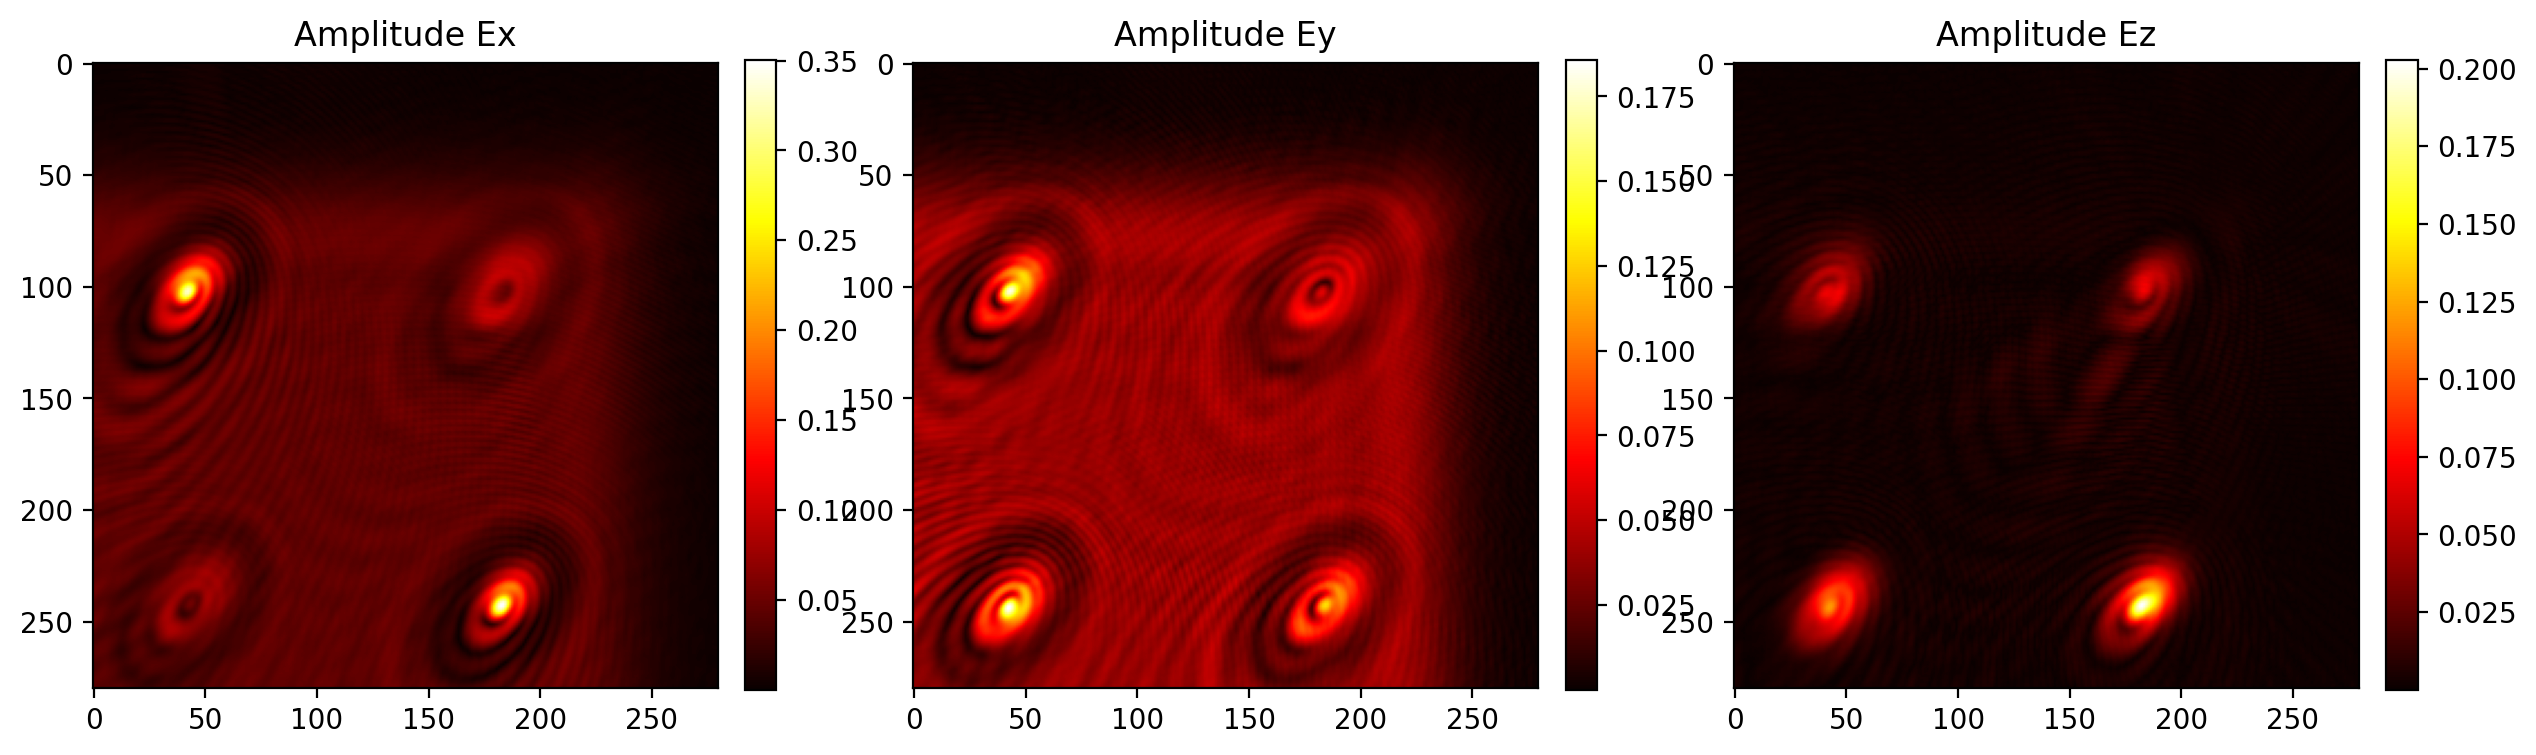

In [137]:
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.title("Amplitude Ex")
plt.imshow(amplitude[..., 2], cmap="hot")
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(132)
plt.title("Amplitude Ey")
plt.imshow(amplitude[..., 1], cmap="hot")
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(133)
plt.title("Amplitude Ez")
plt.imshow(amplitude[..., 0], cmap="hot")
plt.colorbar(fraction=0.046, pad=0.04)

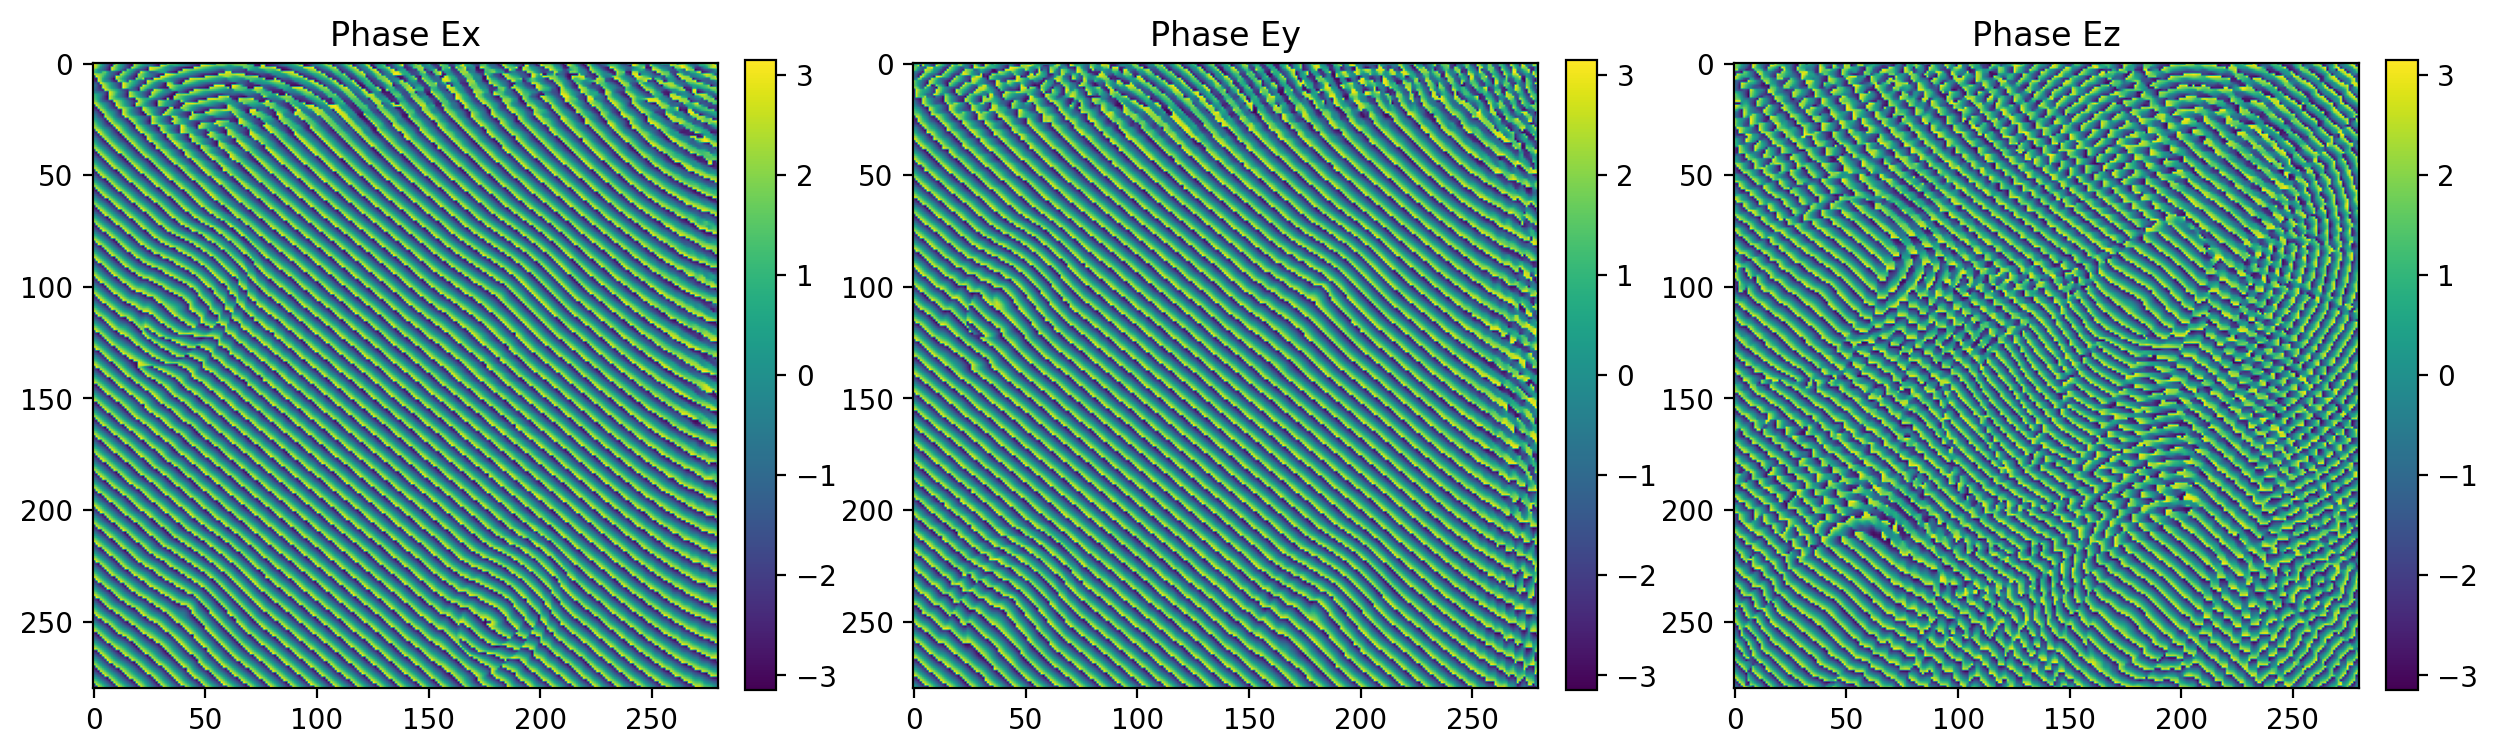

In [136]:
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.title("Phase Ex")
plt.imshow(phase[..., 2])
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(132)
plt.title("Phase Ey")
plt.imshow(phase[..., 1])
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(133)
plt.title("Phase Ez")
plt.imshow(phase[..., 0])
plt.colorbar(fraction=0.046, pad=0.04)